In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import scipy.linalg as spla

from func import *
from math import log

## Citation

Borrowed:
1. Michael Heath's Interpolation [Slides](https://relate.cs.illinois.edu/course/cs450-f18/f/lectures/heath/chap07.pdf)
1. Edgar Solomonik's Interpolation [Slides](https://relate.cs.illinois.edu/course/cs450-f18/f/lectures/07-lecture.pdf)
1. [Scientific Computing: An Introductory Survey](http://heath.cs.illinois.edu/scicomp/) by Michael Heath

## Background

Stocks are hard to predict. While they have a predictive pattern of moving up and down, many day-traders try to exploit the market by buying and selling stocks when they hit the support or resistance lines, knowing that it will rebound either up or down respectively. (For more info, look [here](https://www.investopedia.com/trading/support-and-resistance-basics/)). 

Another way to make (or lose) money is to see when stocks break these lines. Often times, stock graphs will hit these lines and either do one of two things:
1. Rebound
1. Break 

If it breaks, it will continue it's current trajectory (e.g. keep going up or down). These are fantastic ways to make money if you know when it will break the resistant band, but can be hard to detect. If it rebounds, it just changes it trajectory.

For an example, look at how the stock repeatedly moves up and down, sometimes breaking those imaginary lines to go further up or further down. 

We also show if one perfectly detects the moves of stock, we show an upper bound for the scaled growth over the ~3.5 year span.

Maximum Growth: 31.6759457911815x


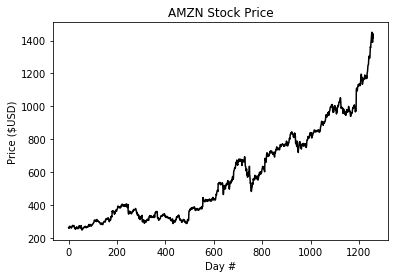

In [2]:
stock = "amzn" # AMZN, GOOG, GOOGL, ABBV, AMGN, NKE

stock = stock.upper()
ogp = getPrices(stock)[1]
plt.plot(np.arange(len(ogp)), ogp, color="black")
plt.title(stock.upper() + " Stock Price"); plt.xlabel("Day #"); plt.ylabel("Price ($USD)")

print("Maximum Growth: {}x".format(sum([abs(ogp[i+1] - ogp[i]) for i in range(len(ogp)-1)])/ogp[0]))

We seek to represent the stock graph as a series of polynomials to determine how the prices are changing with respect to their first and second derivatives. However, representing the graph as a polynomial will be tricky, but will be solvable with a tool called interpolation.

Disclaimer: Going into this analysis (and future), it is not clear that any of this research will lead to concrete, beneficial answers. It may be we find *nothing*, since the market tends to be random with the course of the economy, world trade, and other unknown factors. However, analyzing the price and the derivates *could* be a window into better understanding and underlying factors in what drives the highs and lows of the stock market.

## Motivation

We want to smooth datapoints to extract accurate first and second derivates of the stock prices as a function of time. While library packages exist to solve this for us, we want to go "under the hood" explain how it works and extract the derivates for future analysis of price changes.

We will show a variety of ways to solve it, benefits of each, and how we will implement them.

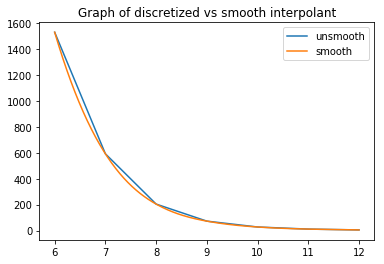

In [3]:
# https://stackoverflow.com/questions/5283649/plot-smooth-line-with-pyplot

from scipy.interpolate import make_interp_spline, BSpline

T = np.array([6, 7, 8, 9, 10, 11, 12])
power = np.array([1.53E+03, 5.92E+02, 2.04E+02, 7.24E+01, 2.72E+01, 1.10E+01, 4.70E+00])

plt.figure(3)
plt.plot(T,power,label="unsmooth")

xnew = np.linspace(T.min(),T.max(),300) #300 represents number of points to make between T.min and T.max

spl = make_interp_spline(T, power, k=3) #BSpline object
power_smooth = spl(xnew)

plt.plot(xnew,power_smooth,label="smooth")
plt.title("Graph of discretized vs smooth interpolant")
plt.legend()
plt.show()

In [4]:
def monoInterpolants(v):
    n = len(v)
    V = vandermonde(n)
    return la.solve(V,v)[::-1]

def monoEval(inter,t):
    y = 0
    for val in inter:
        y = y*t + val # Horner's Rule
    return y

def lagrangeEval(v,times,t):
    n = len(v); y = 0
    for i in range(n):
        y_i = 1; t_i = times[i]
        for j in range(i):
            y_i *= (t - times[j])/(t_i - times[j])
        for j in range(i+1,n):
            y_i *= (t - times[j])/(t_i - times[j])
        y += y_i * v[i]
    return y

In [5]:
_, ogp = getPrices(stock)

# Size of interpolation (this will break if > 16 due to ill-conditioned Vandermonde matrix)
# Change Me
length = 11

# this can be any positive value <= 1259 -> indicates which date to start on
start = 199
assert(start >= 0 and start + length <= 1259)

p = ogp[start:start+length]

# produces a n-1 degree monomial
interpol = monoInterpolants(p)
print("Vandermonde Matrix 2-Norm: {}".format(la.norm(vandermonde(length), ord=2)))

Vandermonde Matrix 2-Norm: 10703927095.997286


## Naive Interpolation

We first show two ways to solve the interpolants. These are good as long as $n < 11$. However, as $n$ increases, we will show an increase in perturbation and thus highly oscillating data points, resulting in unnecessary noise. 

We show the two interpolation techniques
1. [Monomial](https://en.wikipedia.org/wiki/Monomial_basis)
1. [Lagrange](https://en.wikipedia.org/wiki/Lagrange_polynomial)

Monomial excels in have $O(n)$ evaluation time at the expense of $O(n^3)$ time for find the interpolant coefficients. This is especially useful if we want to interpolate many data points.

Lagrange excells in finding the interpolation coefficients in $O(n)$ time since the Vandermonde system is just the identify matrix. The trade-off is that evaluation time is now $O(n^2)$ time. This is great if we only want to interpolate a few points.

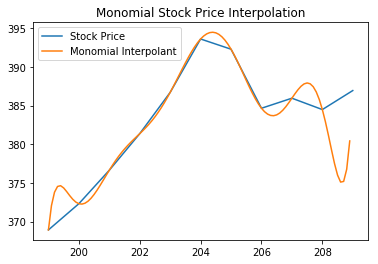

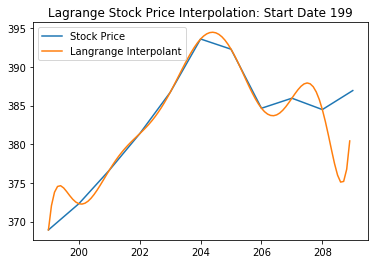

In [6]:
# number of points inbetween dates
inbetween = 10

# plots
plt.figure(1)
plt.title("Monomial Stock Price Interpolation")
plt.plot(np.arange(len(p))+start, p, label="Stock Price")

# Since ill-conditioned matrix produces wild interpolant at the end, we remove the last one
x = np.arange(0, length-1, 1./inbetween)
plt.plot(x+start, np.array([monoEval(interpol, i) for i in x]), label="Monomial Interpolant")
plt.legend()

plt.figure(2)
plt.title("Lagrange Stock Price Interpolation: Start Date {}".format(start))
plt.plot(np.arange(len(p))+start, p, label="Stock Price")

x2 = np.arange(start, start+length)
plt.plot(x+start, np.array([lagrangeEval(p, x2, i+start) for i in x]), label="Langrange Interpolant")
plt.legend()

### Other interpolation techniques

1. [Newton](https://en.wikipedia.org/wiki/Newton_polynomial)
1. [Legendre](https://en.wikipedia.org/wiki/Legendre_polynomials)
1. [Chebyshev](https://en.wikipedia.org/wiki/Chebyshev_polynomials)

Newton is a good mix of trade-offs for solving and evaluating the coefficients. However, it still suffers from the error that Monomial and Langrange experience.

Legendre is a good alternative for orthogonalizing the Monomial basis. This is a valid technique to solve our coefficents, but we do not show the technique here.

Chebyshev helps remove oscilliation at the endpoints by interpolating more points at the end (an answer to the Runge effect). However, since we are given equspaced points on the x-axis (and Chebysheve requires equaspaced points on on the circle), this will be difficult to implement with the data we have.

## Piecewise Polynomial

With some error analysis, we show that our error $E(h)$ is bounded by

$$E(h) \leq O(h^n)$$

This means to reduce error, we can either decrease $h$ (the interpolation size) or increase $n$ (the number of interpolant points). One will find increase points can still lead to more error (as shown with the oscillating points at the end).

Thus, an answer is to decrease the interpolation size. Instead, we seek a family of techniques to decrease $h$ by breaking up the domain into discretized portions.

### Cubic (Natural) Spline

Specificially, we will be looking at Cubic Splines, which is a variation of Piecewise Polynomials.

To understand what Cubic splines, we must remember the purpose of piecewise polynomial: to break up our domain into a series of smaller consecutive domains. One problem is continuity. 

While one domain might have all their points increasing (for generality, we will say it represents $y=x+b$), the next domain could be all the points decreasing (let's say $y=-x+b$). If you graphed this, it would just be two lines that are connected but very jagged. If we did this for all the split domains, the graph would be like a mountain valley: a plethora of discontinuous functions.

Splines aims to fix that by requiring the a $k-1$ differentiability continuity between the split domains. For cubic (3) splines, it means the first and second derivative must be continuous. In addition to the $2(n-1)$ points to interpolate, we gain another $2(n-2)$ interpolation points for the first and second derivatives. Thus we have a total of $4n - 6$ degrees of freedom.

Since a spline requires $4(n-1)$ (this is just a specific DOF) degrees of freedom, the remaining two degrees of freedom are what determines the variation of the Cubic spline.

In this case, we will use **natural splines**, which uses the last two DOF to require the last two second derivates to be 0.

### How to build the Cubic Spline Problem

We remember we are solving a system that must:
1. Solve for coefficients of a degree-3 polynomial $n$ times
1. The first derivative between interpolants must match
1. The second derivative between interpolants must match
1. The first and last second derivative must be 0

With these in mind, we will show how to solve this with a canonical example. Let's say we are interpolating two interpolants $\begin{bmatrix} t_1 & t_2 \end{bmatrix}$ and $\begin{bmatrix} t_2 & t_3 \end{bmatrix}$. With $n=3$ points, our total degree of freedoms will be $4 \times (3-1) = 8$.

We represent our 4th-order (degree 3) polynomial for each interpolant as

$$p_0(t) = \eta_1 + \eta_2t + \eta_3t^2 + \eta_4t^3$$
$$p_1(t) = \xi_1 + \xi_2t + \xi_3t^2 + \xi_4t^3$$

In addition to solving these coefficients, we require that:
1. $p_0(t_2) = p_1(t_2)$ to ensure our values are connected
1. $p_0'(t) - p_1'(t) = 0$ to ensure the first derivative matches
1. $p_0''(t) - p_1''(t) = 0$ to ensure the second derivative matches
1. $p_0''(t) = p_1''(t) = 0$ to ensure the natural spline

Given interpolant points $(t_i, y_i)$ for $i = 1,2,3$, we get our linear system of:

$$
\begin{bmatrix}
1 & t_1 & t_1^2 & t_1^3 & 0 & 0 & 0 & 0 \\
1 & t_2 & t_2^2 & t_2^3 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & t_2 & t_2^2 & t_2^3 \\
0 & 0 & 0 & 0 & 1 & t_3 & t_3^2 & t_3^3 \\
0 & 1 & 2t_2 & 3t_2^2 & 0 & -1 & -2t_2 & -3t_2^2 \\
0 & 0 & 2 & 6t_2 & 0 & 0 & -2 & -6t_2 \\
0 & 0 & 2 & 6t_1 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 2 & 6t_3 
\end{bmatrix}
\begin{bmatrix}
\eta_1 \\ \eta_2 \\ \eta_3 \\ \eta_4 \\ \xi_1 \\ \xi_2 \\ \xi_3 \\ \xi_4
\end{bmatrix}
=
\begin{bmatrix}
y_1 \\ y_2 \\ y_2 \\ y_3 \\ 0 \\ 0 \\ 0 \\ 0
\end{bmatrix}
$$

In [7]:
def evaulateCubicSpline(coeff, xCoor, evalPts, order=0):
    # ensures 4(n-1) degrees of freedom
    assert(len(coeff) == 4 * (len(xCoor) - 1))
    
    ys = np.zeros(0)
    splineIdx = 0
    
    for t in evalPts:
        while not (xCoor[splineIdx//4] <= t <= xCoor[splineIdx//4 + 1]):  
            splineIdx += 4
            if splineIdx >= len(coeff)-3:
                print("Error: Evaluation point {} outside of spline endpoint {}".\
                     format(t, xCoor[-1]))
                assert(False)  
        
        if order == 0:
            val = coeff[splineIdx] + coeff[splineIdx+1]*t + coeff[splineIdx+2]*t**2 + coeff[splineIdx+3]*t**3
        elif order == 1:
            val = coeff[splineIdx+1] + 2*coeff[splineIdx+2]*t + 3*coeff[splineIdx+3]*t**2
        elif order == 2:
            val = 2*coeff[splineIdx+2] + 6*coeff[splineIdx+3]*t
        else:
            print("Error: order must be between [0,2], got {}".format(order))
            assert(False)
            
        ys = np.append(ys, val)
        
    return ys

In [8]:
length = len(ogp)
steps = 1

p = ogp[:length]

equaTime = np.arange(length)
# first derivative doesn't like equally spaced points
evalTime = np.linspace(0,length-1,length+1)
coeff = cubicSplineCoeff(p, equaTime)

Interpolation Relative error: 9.046594593146815e-08


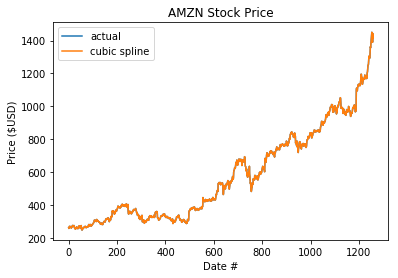

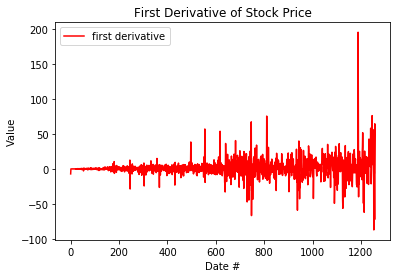

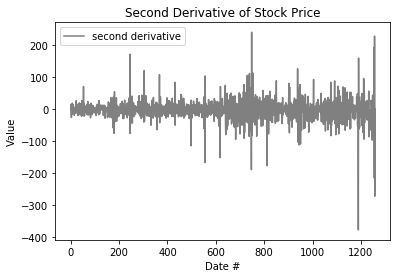

In [9]:
plt.figure(5)
plt.title(stock + " Stock Price")
pts = evaulateCubicSpline(coeff, equaTime, equaTime)
plt.plot(equaTime, p, label="actual")
plt.plot(equaTime, pts, label="cubic spline")
plt.xlabel("Date #")
plt.ylabel("Price ($USD)")
plt.legend()

print("Interpolation Relative error: {}".format(la.norm(pts[::steps] - p, ord=2)/la.norm(p, ord=2)))

plt.figure(6)
der1 = evaulateCubicSpline(coeff, equaTime, evalTime, order=1)
plt.title("First Derivative of Stock Price")
plt.plot(evalTime, der1, label="first derivative", color="red")
plt.xlabel("Date #")
plt.ylabel("Value")
plt.legend()

plt.figure(7)
plt.title("Second Derivative of Stock Price")
der2 = evaulateCubicSpline(coeff, equaTime, equaTime, order=2)
plt.plot(equaTime, der2, label="second derivative", color="grey")
plt.xlabel("Date #")
plt.ylabel("Value")
plt.legend()

## Continous Spline

We note as the size $n$ of the points grow, the computation can get very expensive, as the solve requires $O(n^3)$ work. It would be a dream if we could connect different cubic splines. This is possible with our extra two degree of freedoms. 

Rather than sticking to the natural spline where the first and last second-derivative are required to be 0, we could define a continous spline that defines the first and last first-derivative of the first point. This can us help connect future splines together. For instance, if we know the first and second derivative of the last point of a spline, we can require the next spline start with those values. One could think of this as a spline of splines.

To get the spline started, we can make guesses as to what the derivates are. We estimate this using finite differenes, where we just take the rate of change between the first two points and the last two points.

Given an arbitrary max spline size $b$, we show the computation now is:

$$O(nb^2)$$

If we set $b$ to be a constant (say 100), one could argue our run time now is roughly:

$$O(n)$$

Much better than $O(n^3)$! 

$$\textrm{"Life is good." - Eric Rosen}$$

An arguement could be made: Why not make $b$ arbitrarily small?

One benefit of the spline is the smoothness. While good for interpolating in general, it can also become a negative. Introduing more splines which entails more connected cubic functions could lead to unnecessary noise since the Cubic spline tries to smooth everything out. Thus, reaching a happy medium (say, $b=100$) allows us to have low error, fast run times, and still a smooth function.

In [10]:
def continousSplineCoeff(p,time,maxSize=100):
    assert(len(p) == len(time))
    n = 0
    coeff = np.zeros(0)
    maxSize = min(maxSize, len(p))
        
    while(n < len(p)):
        if(len(p) - n - maxSize <= 4):
            maxSize += len(p) - n

        maxSize = min(maxSize, len(p) - n)
            
        dv1 = (p[n+1] - p[n])/(time[n+1] - time[n])
        dv2 = (p[n+maxSize-1] - p[n+maxSize-2])/(time[n+maxSize-1] - p[n+maxSize-2])
        
        A,b = contCubicSplineLinSys(p[n:n+maxSize+1],dv1,dv2,time[n:n+maxSize+1])
        Q,R = la.qr(A)
        coeff = np.append(coeff, spla.solve_triangular(R, np.dot(Q.T, b)))
        
        n += maxSize
    
    return coeff

Interpolation Relative error: 3.5990165318025154e-08


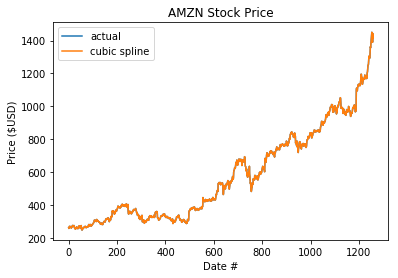

In [11]:
contCoeff = continousSplineCoeff(p, equaTime)
pts2 = evaulateCubicSpline(contCoeff, equaTime, equaTime)

plt.figure(10)
plt.title(stock + " Stock Price")
plt.plot(equaTime, p, label="actual")
plt.plot(equaTime, pts2[:], label="cubic spline")
plt.xlabel("Date #")
plt.ylabel("Price ($USD)")
plt.legend()
print("Interpolation Relative error: {}".format(la.norm(pts2[::steps] - p, ord=2)/la.norm(p, ord=2)))